<a href="https://colab.research.google.com/github/Sxela/flow_tools/blob/main/flow_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make file

In [3]:
#@title Create start.py
%%writefile check_consistency.py

import argparse
import PIL.Image
import numpy as np
import scipy.ndimage
import glob
from tqdm import tqdm

def make_consistency(flow1, flow2, edges_unreliable=False):
      # Awesome pythonic consistency check from [maua](https://github.com/maua-maua-maua/maua/blob/44485c745c65cf9d83cb1b1c792a177588e9c9fc/maua/flow/consistency.py) by Hans Brouwer and Henry Rachootin
      # algorithm based on https://github.com/manuelruder/artistic-videos/blob/master/consistencyChecker/consistencyChecker.cpp
      # reimplemented in numpy by Hans Brouwer
      # // consistencyChecker
      # // Check consistency of forward flow via backward flow.
      # // (c) Manuel Ruder, Alexey Dosovitskiy, Thomas Brox 2016

      flow1 = np.flip(flow1, axis=2)
      flow2 = np.flip(flow2, axis=2)
      h, w, _ = flow1.shape

      # get grid of coordinates for each pixel
      orig_coord = np.flip(np.mgrid[:w, :h], 0).T

      # find where the flow1 maps each pixel
      warp_coord = orig_coord + flow1

      # clip the coordinates in bounds and round down
      warp_coord_inbound = np.zeros_like(warp_coord)
      warp_coord_inbound[..., 0] = np.clip(warp_coord[..., 0], 0, h - 2)
      warp_coord_inbound[..., 1] = np.clip(warp_coord[..., 1], 0, w - 2)
      warp_coord_floor = np.floor(warp_coord_inbound).astype(int)

      # for each pixel: bilinear interpolation of the corresponding flow2 values around the point mapped to by flow1
      alpha = warp_coord_inbound - warp_coord_floor
      flow2_00 = flow2[warp_coord_floor[..., 0], warp_coord_floor[..., 1]]
      flow2_01 = flow2[warp_coord_floor[..., 0], warp_coord_floor[..., 1] + 1]
      flow2_10 = flow2[warp_coord_floor[..., 0] + 1, warp_coord_floor[..., 1]]
      flow2_11 = flow2[warp_coord_floor[..., 0] + 1, warp_coord_floor[..., 1] + 1]
      flow2_0_blend = (1 - alpha[..., 1, None]) * flow2_00 + alpha[..., 1, None] * flow2_01
      flow2_1_blend = (1 - alpha[..., 1, None]) * flow2_10 + alpha[..., 1, None] * flow2_11
      warp_coord_flow2 = (1 - alpha[..., 0, None]) * flow2_0_blend + alpha[..., 0, None] * flow2_1_blend

      # coordinates that flow2 remaps each flow1-mapped pixel to
      rewarp_coord = warp_coord + warp_coord_flow2

      # where the difference in position after flow1 and flow2 are applied is larger than a threshold there is likely an
      # occlusion. set values to -1 so the final gaussian blur will spread the value a couple pixels around this area
      squared_diff = np.sum((rewarp_coord - orig_coord) ** 2, axis=2)
      threshold = 0.01 * np.sum(warp_coord_flow2 ** 2 + flow1 ** 2, axis=2) + 0.5
      reliable_flow = np.where(squared_diff >= threshold, -0.75, 1)

      # areas mapping outside of the frame are also occluded (don't need extra region around these though, so set 0)
      if edges_unreliable:
          reliable_flow = np.where(
              np.logical_or.reduce(
                  (
                      warp_coord[..., 0] < 0,
                      warp_coord[..., 1] < 0,
                      warp_coord[..., 0] >= h - 1,
                      warp_coord[..., 1] >= w - 1,
                  )
              ),
              0,
              reliable_flow,
          )

      # get derivative of flow, large changes in derivative => edge of moving object
      dx = np.diff(flow1, axis=1, append=0)
      dy = np.diff(flow1, axis=0, append=0)
      motion_edge = np.sum(dx ** 2 + dy ** 2, axis=2)
      motion_threshold = 0.01 * np.sum(flow1 ** 2, axis=2) + 0.002
      reliable_flow = np.where(np.logical_and(motion_edge > motion_threshold, reliable_flow != -0.75), 0, reliable_flow)

      return reliable_flow


parser = argparse.ArgumentParser()
parser.add_argument("--flow_fwd", type=str, required=True, help="Forward flow path or glob pattern")
parser.add_argument("--flow_bwd", type=str, required=True, help="Backward flow path or glob pattern")
parser.add_argument("--output", type=str, required=True, help="Output consistency map path")
parser.add_argument("--output_postfix", type=str, default='_cc', help="Output consistency map name postfix")
parser.add_argument("--image_output", action='store_true', help="Output consistency map as b\w image path")
parser.add_argument("--blur", type=float, default=2., help="Gaussian blur kernel size (0 for no blur)")
parser.add_argument("--bottom_clamp", type=float, default=0., help="Clamp lower values")
parser.add_argument("--edges_reliable", action='store_true', help="Consider edges reliable")
args = parser.parse_args()

def run(args):
  flow_fwd_many = sorted(glob.glob(args.flow_fwd))
  flow_bwd_many = sorted(glob.glob(args.flow_bwd))
  if len(flow_fwd_many)!= len(flow_bwd_many): 
    raise Exception('Forward and backward flow file numbers don`t match')
    return
  
  for flow_fwd,flow_bwd in tqdm(zip(flow_fwd_many, flow_bwd_many)):
    flow1 = np.load(flow_fwd)
    flow2 = np.load(flow_bwd)
    consistency_map = make_consistency(flow1, flow2, edges_unreliable=not args.edges_reliable)

    # blur
    if args.blur>0.:
      consistency_map = scipy.ndimage.gaussian_filter(consistency_map, [args.blur, args.blur])

    #clip values between bottom_clamp and 1
    bottom_clamp = min(max(args.bottom_clamp,0.), 0.999)
    consistency_map = consistency_map.clip(bottom_clamp, 1)
    out_fname = args.output+'/'+flow_fwd.split('/')[-1][:-4]+args.output_postfix
    np.save(out_fname, consistency_map)

    #save as jpeg 
    if args.image_output:
      PIL.Image.fromarray((consistency_map*255.).astype('uint8')).save(out_fname+'.jpg')

run(args)

Overwriting check_consistency.py


# Check consistency

In [4]:
!python /content/check_consistency.py --flow_fwd /content/00*.jpg.npy --flow_bwd /content/00*.jpg_12.npy --output /content/ --output_postfix="-21_cc" --image_output

1it [00:00,  4.24it/s]


# Validate

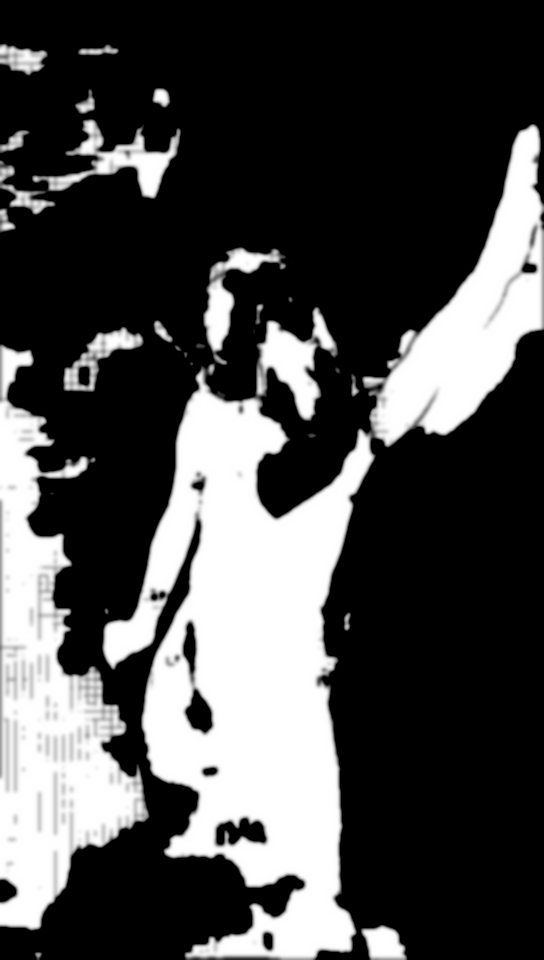

((960, 544), 0.0, 1.0)

In [8]:
import numpy as np
import PIL.Image

weights = np.load('/content/0061.jpg-21_cc.npy'); 
display(PIL.Image.fromarray(((weights).clip(0., 1)*255).astype('uint8')))
weights.shape, weights.min(), weights.max()

In [9]:
!python /content/check_consistency.py --help

usage: check_consistency.py [-h] --flow_fwd FLOW_FWD --flow_bwd FLOW_BWD
                            --output OUTPUT [--output_postfix OUTPUT_POSTFIX]
                            [--image_output] [--blur BLUR]
                            [--bottom_clamp BOTTOM_CLAMP] [--edges_reliable]

optional arguments:
  -h, --help            show this help message and exit
  --flow_fwd FLOW_FWD   Forward flow path or glob pattern
  --flow_bwd FLOW_BWD   Backward flow path or glob pattern
  --output OUTPUT       Output consistency map path
  --output_postfix OUTPUT_POSTFIX
                        Output consistency map name postfix
  --image_output        Output consistency map as b\w image path
  --blur BLUR           Gaussian blur kernel size (0 for no blur)
  --bottom_clamp BOTTOM_CLAMP
                        Clamp lower values
  --edges_reliable      Consider edges reliable
